# Q8 Analyze HRV

Dig into the Rhinovirus results in the Q8 sequencing run.

In prior RespiCoV analyses I've relied on hits caching to enable fast analysis. But in Q8 I have a ton more data (28 Gb uncompressed, 22M reads) using a variety of different primers, as well as a lot of samples using only Rhinovirus primers. So rather than use hits caching, let's just split out the entire set of Rhinovirus hits and operate on that. 

This looks over all Q8a/b sequencing reads for the HRV 5' UTR region targetted by the RespiCoV Enterovirus primer pair. Most experiments actually used the HRVKa5 primer set, but they different from ENT rc only in the reverse primer extending 2 bases further beyond the amplicon, so we can just ignore that.

Note that these samples also include a full-genome HRV sequence which we want to exclude.
Reads were basecalled and demuxed with Dorado 0.7.3, using the hac@v5.0.0 model and with barcodes and adapters trimmed.
Reads have not yet been filtered for quality, we do that here.

## Setup

In [25]:
from Bio import Align
import matplotlib_inline.backend_inline
import os
import pandas as pd
import RCUtils
import random
import numpy as np

%load_ext autoreload
%autoreload 1
%aimport RCUtils

# Be deterministic
random.seed(42)

fastQDir = "../Q8/reads-hac/"

pd.options.display.max_rows = 50
pd.options.display.min_rows = 25

# Get the Rhinovirus primer pair.
rcPrimers = RCUtils.readPrimers("RespiCovPrimers.fasta")
hrvPrimers = [p for p in rcPrimers if p.description == "Rhinovirus/Enterovirus 1" or p.description == "Rhinovirus/Enterovirus 3"]
print("Rhinovirus primers:", [str(p.seq) for p in hrvPrimers])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Rhinovirus primers: ['CAAGCACTTCTGTTTCCCCGG', 'AACACGGACACCCAAAGTAGT']


## Utilities

In [78]:
import math

# Get the hits across all files but allow a limit on the number of reads per file.
# Many files have over a million reads.
def getAllPrimerHits(maxReadsPerFile = 0, progress = False, skipReads = 0):
    for file in sorted(filter(lambda f: f.endswith(".fastq.gz"), os.listdir(fastQDir))):
        # Skip the 3rd sequencing run results because those samples were SC2 only
        if file.startswith("Q8c-"):
            continue
    
        for (read, hit) in getPrimerHits(file, maxReadsPerFile, progress, skipReads):
            yield (file, read, hit)

# Get primer hits for a single file
def getPrimerHits(file, maxReadsPerFile = 0, progress = False, skipReads = 0, matchThreshold = RCUtils.MATCH_THRESHOLD):
    fastQPath = os.path.join(fastQDir, file)
    if progress:
        print("Processing ", os.path.basename(fastQPath), end="")
    reads = 0
    hitReads = 0
    for read in RCUtils.readFastQ(fastQPath):
        reads += 1
        if reads <= skipReads:
            continue
        hits = RCUtils.computePrimerHits(read, hrvPrimers, matchThreshold=matchThreshold)
        if hits:
            hitReads += 1
            yield (read, hits)
        if maxReadsPerFile and reads >= skipReads + maxReadsPerFile:
            break
    if progress:
        totalReads = max(reads - skipReads, 0)
        print(" %d reads, %d with hits (%d%%)" % (totalReads, hitReads, hitReads * 100 / totalReads if totalReads else 0))

# Compute an overall probability of error as a phred score
# This tends to higly penalize a single error, so may not be as useful as the mean phred score
def overallPhredScore(phred_scores):
    # Phred scores represent the probability of error, eg. with 10 being 1 in 10, 20 being 1 in 100, etc.
    total_error_prob = 1 - math.prod(1 - 10 ** (-q / 10) for q in phred_scores)
    if total_error_prob == 0:
        return float('inf')
    return -10 * math.log10(total_error_prob)

# Print an alignment with an additional track indicating the quality scores of the read
def printAlignmentWithQuality(alignment, read):
    assert(alignment.target is read.seq)
    quality_scores = read.letter_annotations["phred_quality"]
    
    # Initialize strings for the aligned target, query, alignment string, and query quality scores
    aligned_target = ""
    aligned_query = ""
    alignment_string = ""
    aligned_target_quality = ""
    
    # Use indices to determine where gaps are and construct the alignment, target, query, and quality strings

    for t_index, q_index in zip(*alignment.indices):
        aligned_target += alignment.target[t_index] if t_index != -1 else "-"
        aligned_query += alignment.query[q_index] if q_index != -1 else "-"
        alignment_string += "|" if t_index != -1 and q_index != -1 and alignment.target[t_index] == alignment.query[q_index] else "."
        if t_index == -1:
            aligned_target_quality += "-"
        else:
            ns = quality_scores[t_index] // 4
            aligned_target_quality += str(ns) if ns < 10 else "9"

    tstart = alignment.indices[0,0]
    tend = alignment.indices[0,-1]
    print("target quality     ", aligned_target_quality, "  avg:", int(np.mean(quality_scores[tstart:tend])))
    print("target             ", aligned_target)
    print("                   ", alignment_string)
    print("query              ", aligned_query)
    print("")


## Get an idea for the distribution of reads with hits

Barcodes 1 to 7 are our main HRV samples and as expected have the bulk of the hits.
Barcodes 19-21 are RespiCoV and so are expected to have some HRV.
Barcode 18 is the HRV-C1 full genome. Why don't we see hits here? Shouldn't I have to filter out these ~1200bp HRV hits?
A few of the other hits occur in samples using other RespiCov primers but not HRV, why?

In [52]:
hitCount = 0
for (file, read, hits) in getAllPrimerHits(maxReadsPerFile=1000, progress=True):
    hitCount += len(hits)

print("Total hits:", hitCount)

Processing  Q8a-hac_barcode01.fastq.gz 1000 reads, 946 with hits (94%)
Processing  Q8a-hac_barcode02.fastq.gz 1000 reads, 888 with hits (88%)
Processing  Q8a-hac_barcode03.fastq.gz 1000 reads, 947 with hits (94%)
Processing  Q8a-hac_barcode04.fastq.gz 1000 reads, 875 with hits (87%)
Processing  Q8a-hac_barcode05.fastq.gz 1000 reads, 918 with hits (91%)
Processing  Q8a-hac_barcode06.fastq.gz 1000 reads, 916 with hits (91%)
Processing  Q8a-hac_barcode07.fastq.gz 1000 reads, 970 with hits (97%)
Processing  Q8a-hac_barcode11.fastq.gz 1000 reads, 9 with hits (0%)
Processing  Q8a-hac_barcode12.fastq.gz 1000 reads, 383 with hits (38%)
Processing  Q8a-hac_barcode13.fastq.gz 1000 reads, 5 with hits (0%)
Processing  Q8a-hac_barcode14.fastq.gz 1000 reads, 121 with hits (12%)
Processing  Q8a-hac_barcode15.fastq.gz 1000 reads, 1 with hits (0%)
Processing  Q8a-hac_barcode16.fastq.gz 1000 reads, 69 with hits (6%)
Processing  Q8a-hac_barcode17.fastq.gz 1000 reads, 9 with hits (0%)
Processing  Q8a-hac_

## Look at the first few hits in detail just to sanity check

These look good. Primer pair hits at the exact start and end of the trimmed read.
Mismatches seem to be in areas of low basecall quality.

In [47]:
from Bio import Align

for (read, hits) in getPrimerHits("Q8a-hac_barcode01.fastq.gz", maxReadsPerFile=5):
    print ("%s %d" % (read.id, len(read)))
    for hit in hits:
        print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))
        aligner = Align.PairwiseAligner(mode='local', match_score=1, mismatch_score=0, gap_score=-1)
        alignment = aligner.align(read.seq, hit.primer.rcSeq if hit.rev else hit.primer.seq)[0]
        RCUtils.extendAlignment(alignment)
        printAlignmentWithQuality(alignment, read)


bbe4b3b4-92cc-4ded-8674-52697668e304 387
   0.95 0-22: Rhinovirus/Enterovirus 3 (21)
target quality      7766666667777788882112   avg: 26
target              AACACGGACACCCAAAGTCAGT
                    ||||||||||||||||||.|||
query               AACACGGACACCCAAAGT-AGT

   0.90 368-387: Rhinovirus/Enterovirus 1 (21 rev)
target quality      6656676777778866666--   avg: 27
target              CCGGGGAAACAGAAGTGCT--
                    |||||||||||||||||||..
query               CCGGGGAAACAGAAGTGCTTG

21b616e1-0b07-4359-bbe1-b46ea58bbffa 389
   1.00 0-21: Rhinovirus/Enterovirus 3 (21)
target quality      667444467888899998776   avg: 29
target              AACACGGACACCCAAAGTAGT
                    |||||||||||||||||||||
query               AACACGGACACCCAAAGTAGT

   1.00 367-388: Rhinovirus/Enterovirus 1 (21 rev)
target quality      888778899988998555999   avg: 33
target              CCGGGGAAACAGAAGTGCTTG
                    |||||||||||||||||||||
query               CCGGGGAAACAGAAGTGCTTG

6a4010fc

## Match score distributions

We're using a default match threshold of 0.8. Make sure that still looks reasonable by comparing the distribution beyond that.
This looks only at the start of one barcode group, it will vary later in the read sequence. This (along with the examples above) also confirms that we'd be throwing away a lot of good matches if we required an exact match.

9358 of 19726 (47%) of primer hits are a perfect match


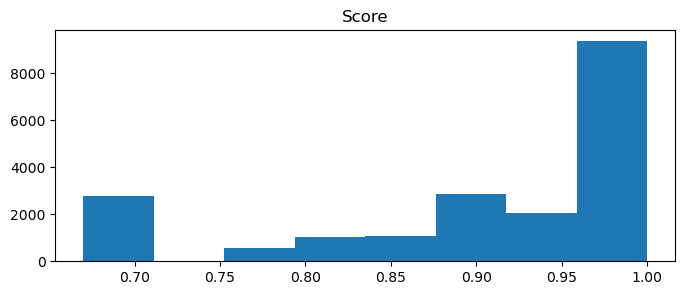

In [79]:
mrs = []
perfect = 0
for (read, hits) in getPrimerHits("Q8a-hac_barcode01.fastq.gz", maxReadsPerFile=10000, matchThreshold = 0.65):
    for hit in hits:
        mrs.append(hit.mr)
        if hit.mr == 1.0:
            perfect += 1

print("%d of %d (%d%%) of primer hits are a perfect match" % (perfect, len(mrs), 100*perfect/len(mrs)))
pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=8, grid=False);

## Distribution of read lengths with hits.

HRV amplicons are expected to be about 390 bp, and indeed the vast majority are.

Reads: 9488, less than 450: 9403 (99%)


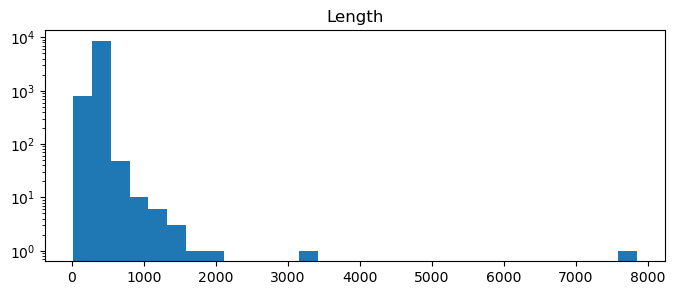

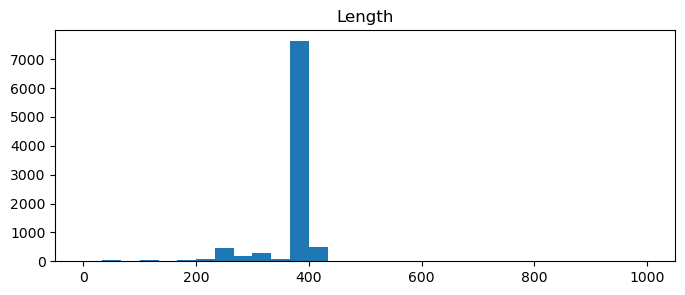

In [90]:
lens = []
reads = 0
lessThan450 = 0
for (read, hits) in getPrimerHits("Q8a-hac_barcode01.fastq.gz", maxReadsPerFile=10000):
    reads += 1
    if len(read) < 450:
        lessThan450 += 1
    lens.append(len(read))

print("Reads: %d, less than 450: %d (%d%%)" % (reads, lessThan450, 100*lessThan450/reads))

pd.DataFrame({'Length': lens}).hist(figsize=(8,3), bins=30, grid=False, log=True)
plt.show()

pd.DataFrame({'Length': lens}).hist(figsize=(8,3), bins=30, grid=False, range=(0, 1000))
plt.show()


## Distribution of hit locations

Perhaps we could make things a lot faster by looking only at the start and end of the read for hits? With dorado having done read splitting and adapter trimming for us, perhaps all legit primers will really be at the start and end of reads?

Hits: 16184, exact: 8777 (54%), within 10: 16066 (99%)


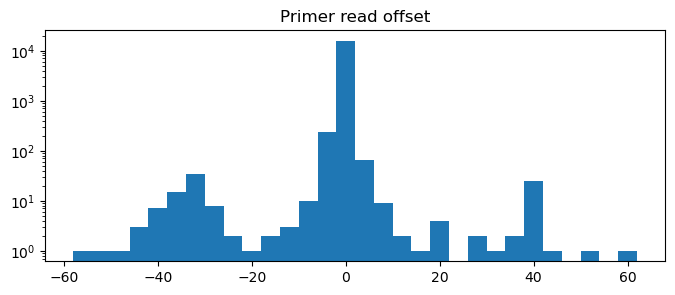

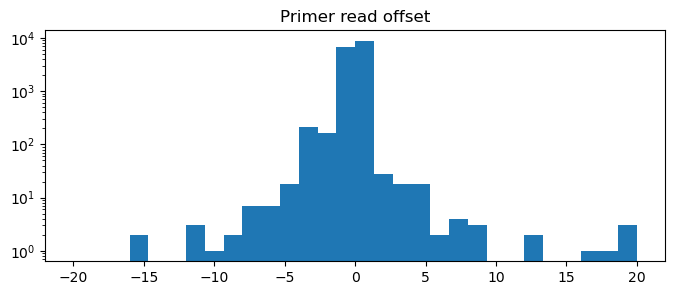

In [91]:
import matplotlib.pyplot as plt

offsets = []
hitCount = 0
exactHit = 0
within10 = 0

for (read, hits) in getPrimerHits("Q8a-hac_barcode01.fastq.gz", maxReadsPerFile=10000):
    if len(read) > 450:
        continue
    for hit in hits:
        hitCount += 1
        so = hit.start
        eo = len(read) - hit.end
        if min(so, eo) == 0:
            exactHit += 1
        if min(so, eo) <= 10:
            within10 += 1
        if (so < eo):
            offsets.append(so)
        else:
            offsets.append(-eo)

print("Hits: %d, exact: %d (%d%%), within 10: %d (%d%%)" % (hitCount, exactHit, 100*exactHit/hitCount, within10, 100*within10/hitCount))
df = pd.DataFrame({'Primer read offset': offsets})
ax = df.hist(figsize=(8,3), bins=30, grid=False, log=True)
plt.show()

ax = df.hist(figsize=(8,3), bins=30, grid=False, log=True, range=(-20,20))
plt.show()